In [1]:
import random
import gym
import math
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [60]:
class TD_DQN():
    
    def __init__(self,
                 model,
                 n_episodes=1000,
                 n_win_ticks=195,
                 env=gym.make('CartPole-v0'),
                 max_env_steps=None,
                 memory_len=100000,
                 gamma=1.0,
                 epsilon=1.0,
                 epsilon_min=0.01,
                 epsilon_log_decay=0.995,
                 batch_size=64,
                 monitor=False,
                 quiet=False,
                 exploration='epsilon',
                 temperature=4,
                 temp_decay=0.99,
                 temp_decay_per_episode=5):
        
        self.memory = deque(maxlen=memory_len)
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.n_episodes = n_episodes
        self.n_win_ticks = n_win_ticks
        self.batch_size = batch_size
        self.quiet = quiet
        self.model = model
        self.exploration = exploration
        self.temperature = temperature
        self.temp_decay = temp_decay
        self.temp_decay_per_episode = temp_decay_per_episode
        self.scores = []
        self.mean_score = []
        if max_env_steps is not None: self.env._max_episode_steps = max_env_steps

            
    def plot_progress(self):
        """
        Plots episode cumulative reward, per episode
        """
        episode = list(range(len(self.scores)))
        plt.plot(episode, self.scores, color='g')
        
    def plot_mean_progress(self):
        """
        Plots episode cumulative reward, per episode
        """
        episode = list(range(len(self.mean_score)))
        plt.plot(episode, self.mean_score, color='g')

    def remember(self, state, action, reward, next_state, done):
        """
        Append to memory for later experience replay
        """
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, epsilon):
        """
        Epsilon greedy exploration technique
        """
        return self.env.action_space.sample() if (np.random.random() <= epsilon) else np.argmax(self.model.predict(state))
    
    def Boltzmann(self, state, temperature, decay, n_episodes, episode):
        """
        This is an implementation of famous Boltzmann exploration technique.
        Note that temperature parameter should be set to bigger than 0 if you want more randomness,
        if temperature is close to one, then action with highest Q value will be chosen with highest probability.
        """
        
        if episode%n_episodes == 0:
            temperature = temperature*decay
        
        preds = self.model.predict(state)
        
        acts_probs = np.true_divide(np.true_divide(np.exp(preds), temperature),
                                    np.sum(np.true_divide(np.exp(preds), temperature)))
    
        return np.random.choice(self.env.action_space.n, 1, p=acts_probs[0])[0]
            
    def get_epsilon(self, t):
        return max(self.epsilon_min, min(self.epsilon, 1.0 - math.log10((t + 1) * self.epsilon_decay)))

    def preprocess_state(self, state):
        """
        Reshape to feed the network 
        """
        return np.reshape(state, [1, self.env.observation_space.shape[0]])

    def replay(self, batch_size):
        """
        Feeding mini batches to the network
        """
        x_batch, y_batch = [], []
        minibatch = random.sample(
            self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in minibatch:
            y_target = self.model.predict(state)
            y_target[0][action] = reward if done else reward + self.gamma * np.max(self.model.predict(next_state)[0])
            x_batch.append(state[0])
            y_batch.append(y_target[0])
        
        self.model.fit(np.array(x_batch), np.array(y_batch), batch_size=len(x_batch), verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def run(self):
        scores = deque(maxlen=100)

        for e in range(self.n_episodes):
            state = self.preprocess_state(self.env.reset())
            done = False
            while not done:
                self.env.render()
                if self.exploration == 'epsilon':
                    action = self.choose_action(state, self.get_epsilon(e))
                elif self.exploration == 'Boltzmann':
                    action = self.Boltzmann(state=state,
                                            temperature=self.temperature,
                                            decay=self.temp_decay,
                                            n_episodes=self.temp_decay_per_episode,
                                            episode=e)
                    
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.preprocess_state(next_state)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                self.scores.append(reward)

            
            self.mean_score.append(np.mean(self.scores))
            
            if e % 100 == 0 and not self.quiet:
                print('[Episode {}] - Mean survival time over last 100 episodes was {} ticks.'.format(e, np.mean(self.mean_score)))

            self.replay(self.batch_size)
        
        self.env.close()
        return e

In [61]:
pole_model = Sequential()
pole_model.add(Dense(24, input_dim=4, activation='tanh'))
pole_model.add(Dense(48, activation='tanh'))
pole_model.add(Dense(2, activation='linear'))
pole_model.compile(loss='mse', optimizer=Adam(lr=0.01, decay=0.01))

In [66]:
agent = TD_DQN(model=pole_model, n_episodes=100)
agent.run()

[Episode 0] - Mean survival time over last 100 episodes was 1.0 ticks.


99

### The plotting clearly doesn't work for Cartpole

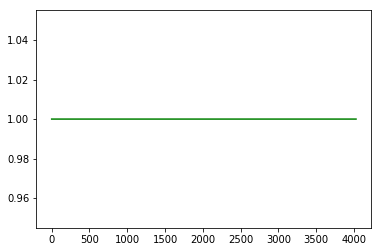

In [69]:
agent.plot_progress()

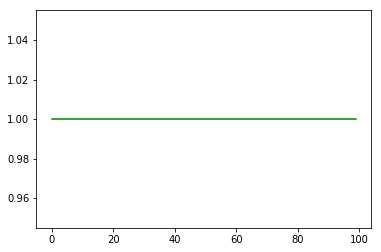

In [70]:
agent.plot_mean_progress()

In [ ]:
agent.env.close()

In [3]:
lunar_game = gym.make('LunarLander-v2')
observation_space = lunar_game.observation_space.shape[0]
action_space = lunar_game.action_space.n

In [4]:
lunar_model = Sequential()
lunar_model.add(Dense(256, input_dim=observation_space, activation="relu"))
lunar_model.add(Dense(256, activation="tanh"))
lunar_model.add(Dense(256, activation="relu"))
lunar_model.add(Dense(256, activation="tanh"))
lunar_model.add(Dense(256, activation="relu"))
lunar_model.add(Dense(256, activation="tanh"))
lunar_model.add(Dense(256, activation="relu"))
lunar_model.add(Dense(256, activation="tanh"))
lunar_model.add(Dense(action_space, activation="linear"))
lunar_model.compile(loss='mse', optimizer=Adam(lr=0.002, decay=0.01))

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
lunar_agent = TD_DQN(n_episodes=20000,
                     model=lunar_model,
                     env=lunar_game,
                     gamma=0.95,
                     batch_size=512,
                     memory_len=1000000,
                     temperature=12,
                     exploration='Boltzmann',
                     temp_decay=0.9,
                     temp_decay_per_episode=10)

In [71]:
lunar_agent.run()

[Episode 0] - Mean survival time over last 100 episodes was -1.134363698809256 ticks.


KeyboardInterrupt: 

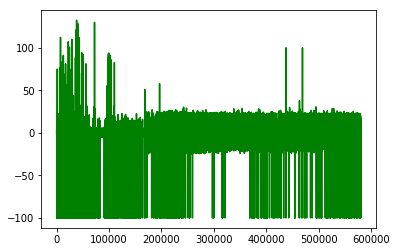

In [73]:
lunar_agent.plot_progress()

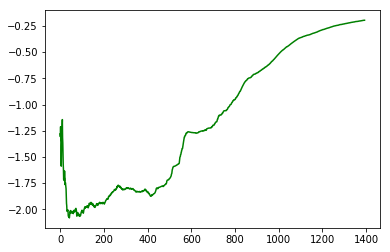

In [74]:
lunar_agent.plot_mean_progress()

### Agent starts to land but doesn't turn off the engine, but I didn't want to wait to train further, maybe it would learn to turn off the engine after landing

In [72]:
lunar_agent.env.close()

In [44]:
breakout = gym.make('Breakout-ram-v0')

In [48]:
break_observation_space = breakout.observation_space.shape[0]
break_action_space = breakout.action_space.n

In [49]:
breakout_model = Sequential()
breakout_model.add(Dense(256, input_dim=break_observation_space, activation="relu"))
breakout_model.add(Dense(256, activation="tanh"))
breakout_model.add(Dense(256, activation="relu"))
breakout_model.add(Dense(256, activation="tanh"))
breakout_model.add(Dense(256, activation="relu"))
breakout_model.add(Dense(256, activation="tanh"))
breakout_model.add(Dense(256, activation="relu"))
breakout_model.add(Dense(256, activation="tanh"))
breakout_model.add(Dense(break_action_space, activation="linear"))
breakout_model.compile(loss='mse', optimizer=Adam(lr=0.002, decay=0.01))

In [50]:
break_agent = TD_DQN(n_episodes=2000,
                     model=breakout_model,
                     env=breakout,
                     gamma=0.95,
                     batch_size=512,
                     memory_len=10000000,
                     temperature=12,
                     exploration='Boltzmann',
                     temp_decay=0.9,
                     temp_decay_per_episode=10)

In [59]:
break_agent.run()

[Episode 0] - Mean survival time over last 100 episodes was 0.00547269240141785 ticks.


KeyboardInterrupt: 

In [64]:
break_agent.env.close()

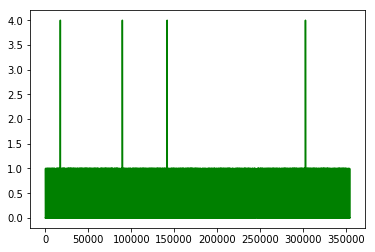

In [56]:
break_agent.plot_progress()

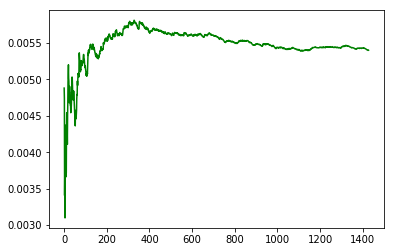

In [57]:
break_agent.plot_mean_progress()